# Developers Salary Predictor

## Introduction

Salary is a fixed amount of money or compensation paid to an employee by an employer in return for work performed. It is tell the reward for carry out a role. While people want a career path they love, it's also essential to go for one that complement your effort, especially at time like this where the global inflation grows without control. \
This project is a part of the 30DaysOfData Science with Microsoft reactor and has the following objective;
- Building the model using python sklearn
- Deploying the model on azure.

In [2]:
import urllib.request
import zipfile
import pandas as pd

url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
file = zip_file_object.open('survey_results_public.csv')

survey_data = pd.read_csv(file)

pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

survey_data.head()

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.00000,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.00000
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.00000,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trell

## Data Wrangling

In [3]:
label = 'ConvertedCompYearly'

# Drop rows without ConcertedCompYearly

survey_data.dropna(subset=label, inplace=True)


# Confirm null removal
sum(survey_data[label].isnull())

0

In [4]:
# Drop extreme outliers

survey_data.drop(survey_data[survey_data[label] > 400000].index, inplace=True)

# validate outlier removal
sum(survey_data[label] > 400000)

0

In [5]:
survey_data[[label]].describe()

,ConvertedCompYearly
count,36260.00000
mean,80720.59956
std,65852.55164
min,1.00000
25%,33888.75000
50%,63986.00000
75%,110000.00000
max,400000.00000


In [6]:
numeric_features = ['YearsCode', 'YearsCodePro']

for col_name in numeric_features:
    survey_data[col_name] = pd.to_numeric(survey_data[col_name], errors='coerce')
    survey_data = survey_data.dropna(subset=[col_name])

survey_data[numeric_features].describe()

,YearsCode,YearsCodePro
count,34685.00000,34685.00000
mean,14.65435,9.84965
std,9.39327,8.06248
min,1.00000,1.00000
25%,8.00000,4.00000
50%,12.00000,7.00000
75%,20.00000,14.00000
max,50.00000,50.00000


## Visualizaing the label column

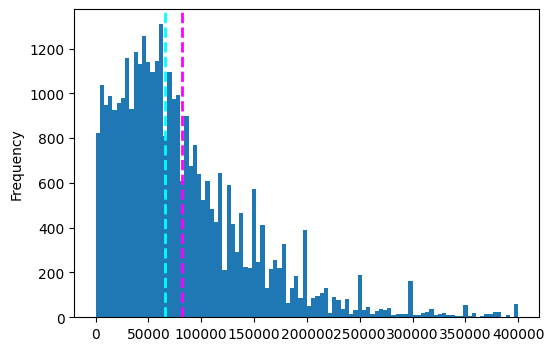

In [7]:
import matplotlib.pyplot as plt

label_data = survey_data[label]
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
ax.hist(label_data, bins=100)
ax.set_ylabel('Frequency')
ax.axvline(label_data.mean(), color='magenta', linestyle='dashed', linewidth = 2)
ax.axvline(label_data.median(), color='cyan', linestyle='dashed', linewidth = 2)

## Visualizing the feature columns

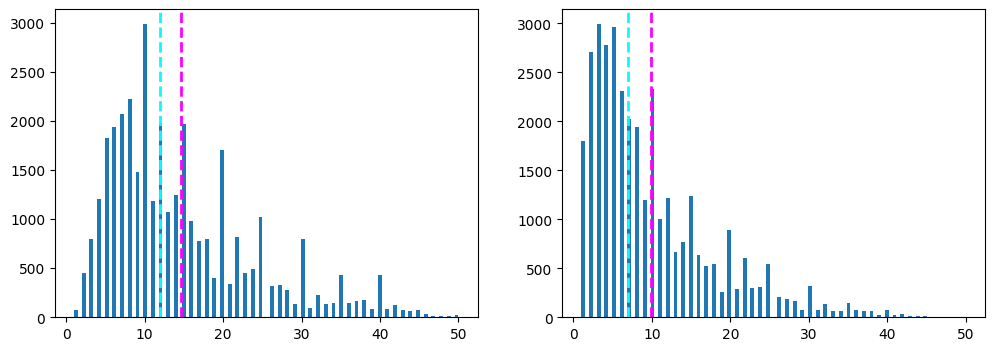

In [8]:
fig, axe = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(12,4))

for ind, col_name in enumerate(numeric_features):

    feauture_data = survey_data[col_name]
    axis = axe[ind]
    
    axis.hist(feauture_data, bins=100)
    
    axis.axvline(feauture_data.mean(), color='magenta', linestyle='dashed', linewidth = 2)
    axis.axvline(feauture_data.median(), color='cyan', linestyle='dashed', linewidth = 2)

## Measuring correlations

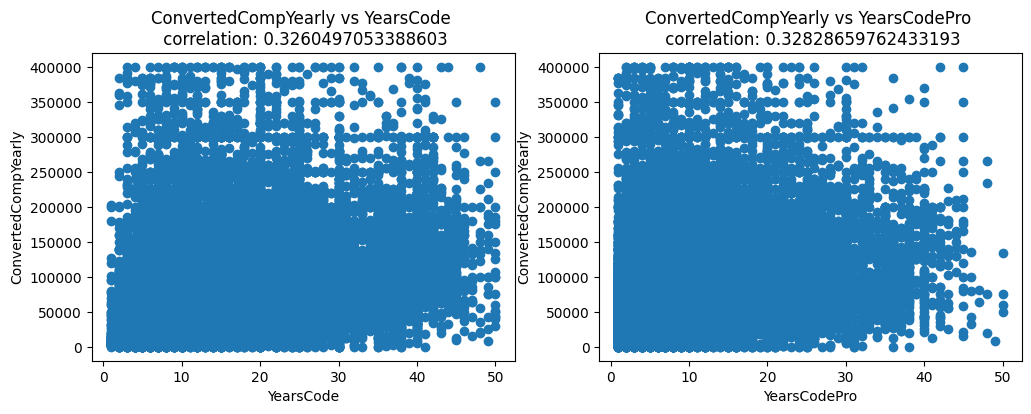

In [9]:
fig, axe = plt.subplots(ncols=len(numeric_features), nrows=1, figsize=(12,4))

for ind, feature in enumerate(numeric_features):
    label_data = survey_data[label]
    feauture_data = survey_data[feature]
    correlation  = feauture_data.corr(label_data)
    axis = axe[ind]
    axis.scatter(feauture_data,label_data)
    axis.set_xlabel(feature)
    axis.set_ylabel(label)
    axis.set_title('{} vs {} \n correlation: {}'.format(label,feature,correlation))
    

## Seperating test and train data

In [16]:
# seperate features and labels
x = survey_data[numeric_features].values
y =survey_data[label].values
print('Features', x[:5], '\nlabels', y[:5], sep='\n')

Features
[[14.  5.]
 [20. 17.]
 [ 6.  6.]
 [ 5.  2.]
 [12. 10.]]

labels
[ 40205. 215232.  49056.  60307. 194400.]


In [22]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=0)

print('Training set: {} rows. \nTest set: {} rows'.format(X_train.shape[0], X_test.shape[0]))

Training set: 26013 rows. 
Test set: 8672 rows


## Training the model

In [23]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train,y_train)
print(model.coef_)
print(model.intercept_)

[1203.43950058 1363.41091693]
51207.87075534298


## Evaluating model on test data

In [24]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)

print('Predicted labels: ', np.round(predictions)[:8])
print('Actual labels   : ', y_test[:8])

Predicted labels:  [83777. 61315. 72626. 60112. 78643. 65969. 67332. 65969.]
Actual labels   :  [47350. 51763. 13212.    50. 38392.  3864. 14952. 58654.]


## Visualizing the prediction

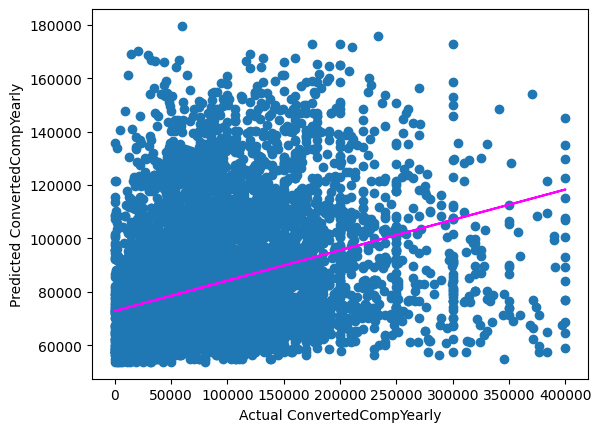

In [28]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual {}'.format(label))
plt.ylabel('Predicted {}'.format(label))

# Overlay the regression line
z= np.polyfit(y_test,predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')

## Calculating evaluation metrics

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print('MSE:', mse)

rmse = mean_squared_error(y_test, predictions, squared=False)
print('RMSE:', rmse)

r2 =r2_score(y_test, predictions)
print('R2:', r2)


MSE: 3869649622.530544
RMSE: 62206.50787924479
R2: 0.11892933995226551


# Experimenting with more models
- Linear algorithms: like Lasso and Ridge other than the Ordinary Least Squares algorithm
- Tree-based algorithms: Algorithms that build a decision tree to reach a prediction
- Ensemble algorithms: Algorithms that combine the outputs of multiple base algorithms improve generalizability.

## Generalizing the evaluation process

In [ ]:
eval_results = pd.DataFrame(columns=['Model',  'RMSE', 'R2'])

def evaluate_models():
    '''
        Models evaluation to show the RMSE and R2 of the different models 
        we would be working with. It would also contain a plot of the plt
        of the relationship between the predicted and the true salaries

        arg:
            None

        return:
            eval_results
            plot of prediction vs actual
    '''

    pass

poly1d([    0.11376507, 72827.74624369])